In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from sklearn.svm import SVR
#from xgboost import XGBRegressor
#from catboost import CatBoostRegressor
#from lightgbm import LGBMRegressor
import joblib

In [6]:
# Load train and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [7]:
# Display the first few rows of the DataFrame
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [8]:
train_df.shape

(90615, 10)

In [9]:
test_df.shape

(60411, 9)

In [10]:
# Check for missing values
train_df.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [11]:
# Check for duplicated values 
duplicates = train_df.duplicated()

# Count the number of duplicated rows
num_duplicates = duplicates.sum()

print("Number of duplicated rows:", num_duplicates)


Number of duplicated rows: 0


<Axes: xlabel='Rings'>

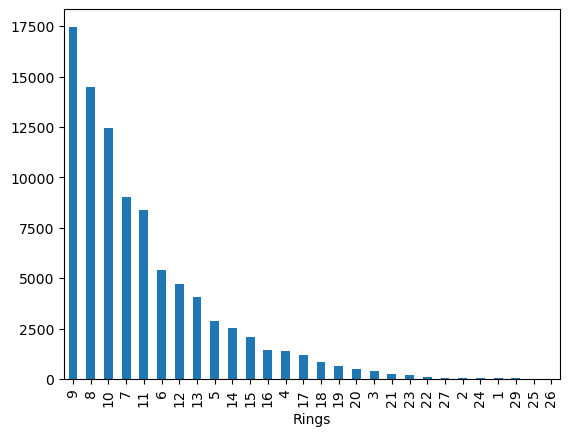

In [12]:
# Visualize the distribution of the target variable (Rings)

train_df['Rings'].value_counts().plot(kind='bar')


In [13]:
# Encode categorical variables

le = LabelEncoder()
train_df['Sex'] = le.fit_transform(train_df['Sex'])
test_df['Sex'] = le.transform(test_df['Sex'])

In [14]:
# Split data into features and target variable

X = train_df.drop(['id', 'Rings'], axis=1)
y = train_df['Rings']
X_test = test_df.drop('id', axis=1)

In [15]:
# Split data into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Define custom RMSLE scorer
def rmsle_score(y_true, y_pred):
    y_true = np.maximum(y_true, 0)  # Ensure y_true is non-negative
    y_pred = np.maximum(y_pred, 0)  # Ensure y_pred is non-negative
    squared_log_errors = (np.log1p(y_pred) - np.log1p(y_true)) ** 2
    mean_squared_log_error = np.mean(squared_log_errors)
    rmsle = np.sqrt(mean_squared_log_error)
    return rmsle


In [17]:
rmsle_scorer = make_scorer(rmsle_score, greater_is_better=False)

In [20]:
# Define models

models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=100, random_state=42),
   # GradientBoostingRegressor(),
    #SVR(),
    #XGBRegressor(),
    #CatBoostRegressor(verbose=0),
    #LGBMRegressor()
]

In [21]:
# Track best model and its RMSLE score
best_model = None
best_model_name = ""
best_rmsle = float('inf')

# Evaluate models
for model in models:
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_val)
    
    # Calculate RMSLE score
    rmsle = rmsle_score(y_val, y_pred)
    
    # Print RMSLE score
    print(f"{model.__class__.__name__}: RMSLE: {rmsle}")
    
    # Update best model if current model has lower RMSLE
    if rmsle < best_rmsle:
        best_model = model
        best_model_name = model.__class__.__name__
        best_rmsle = rmsle

# Print name of the best model
print(f"Best model: {best_model_name}")


LinearRegression: RMSLE: 0.16788369061299604
DecisionTreeRegressor: RMSLE: 0.21697980414208295
RandomForestRegressor: RMSLE: 0.1559158972567478
Best model: RandomForestRegressor


In [22]:
# Train the best performing model on full data
best_model.fit(X, y)

RandomForestRegressor(random_state=42)

In [23]:
# Save the best model using joblib
joblib.dump(best_model, 'best_model')

['best_model']

In [24]:
# Prediction
predictions = best_model.predict(X_test)

In [25]:
# Prepare submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'Rings': predictions})
submission_df.to_csv('submission.csv', index=False)

In [26]:
train_df.columns

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings'],
      dtype='object')

In [27]:
# Single prediction using the best model 
# Load the saved model
import joblib
best_model = joblib.load('best_model')  

# Prepare a dataframe with the features for prediction
# Example Data
data = {'Sex': ['Female'], 
        'Length': [0.455], 
        'Diameter': [0.365], 
        'Height': [0.095], 
        'Whole weight': [0.514],
        'Whole weight.1': [0.2245], 
        'Whole weight.2': [0.101], 
        'Shell weight': [0.15]}
predict_df = pd.DataFrame(data)

# Encode categorical variables
le = LabelEncoder()
predict_df['Sex'] = le.fit_transform(predict_df['Sex'])

# Make prediction
prediction = best_model.predict(predict_df)

print("Predicted Rings:", prediction)

Predicted Rings: [8.67]


### GUI

In [28]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load the best model
best_model = joblib.load('best_model')

# Create a dictionary to store feature names and their respective input widgets
feature_widgets = {}

# Function to predict the rings
def predict_rings():
    try:
        # Get input values from the user
        input_data = []
        for feature, widget in feature_widgets.items():
            if feature == 'Sex':
                input_data.append(sex_encode[widget.get()])
            else:
                input_data.append(float(widget.get()))
        
        # Predict rings using the best model
        prediction = best_model.predict([input_data])[0]
        
        # Show prediction
        messagebox.showinfo("Prediction", f"Predicted number of rings: {prediction}")
    except Exception as e:
        messagebox.showerror("Error", f"Error occurred: {e}")

# Load train data to get feature names for input
train_df = pd.read_csv('train.csv')
feature_names = train_df.columns.drop(['id', 'Rings'])

# Encode Sex feature
le = LabelEncoder()
train_df['Sex'] = le.fit_transform(train_df['Sex'])
sex_encode = {val: key for key, val in enumerate(le.classes_)}

# Create GUI window
root = tk.Tk()
root.title("Predict Rings")

# Function to create input widgets for features
def create_input_widgets():
    for idx, feature in enumerate(feature_names):
        if feature == 'Sex':
            label = ttk.Label(root, text=feature)
            label.grid(row=idx, column=0, padx=5, pady=5, sticky="e")
            sex_options = list(sex_encode.keys())
            sex_var = tk.StringVar(root)
            sex_dropdown = ttk.Combobox(root, textvariable=sex_var, values=sex_options, state="readonly")
            sex_dropdown.grid(row=idx, column=1, padx=5, pady=5, sticky="w")
            feature_widgets[feature] = sex_var
        else:
            label = ttk.Label(root, text=feature)
            label.grid(row=idx, column=0, padx=5, pady=5, sticky="e")
            entry = ttk.Entry(root)
            entry.grid(row=idx, column=1, padx=5, pady=5, sticky="w")
            feature_widgets[feature] = entry

# Function to clear input values
def clear_inputs():
    for widget in feature_widgets.values():
        if isinstance(widget, tk.StringVar):
            widget.set('')
        else:
            widget.delete(0, 'end')

# Function to exit the application
def exit_app():
    root.destroy()

# Create input widgets for features
create_input_widgets()

# Create Predict and Clear buttons
predict_button = ttk.Button(root, text="Predict", command=predict_rings)
predict_button.grid(row=len(feature_names), column=0, columnspan=2, padx=5, pady=10, sticky="we")

clear_button = ttk.Button(root, text="Clear", command=clear_inputs)
clear_button.grid(row=len(feature_names)+1, column=0, columnspan=2, padx=5, pady=5, sticky="we")

exit_button = ttk.Button(root, text="Exit", command=exit_app)
exit_button.grid(row=len(feature_names)+2, column=0, columnspan=2, padx=5, pady=5, sticky="we")

# Run the GUI
root.mainloop()